# WHICH SIMULATION?

In [80]:
simName = 'LES_25'

In [81]:
dayOfInterestUTC     = 28
dayOfSimulationStart = dayOfInterestUTC-1
outPath              = '/glade/scratch/doubrawa/postProcessing/'

# NOTHING NEEDS TO BE MODIFIED BELOW

In [82]:
%matplotlib inline
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import pandas as pd
import xarray
import wrf

In [83]:
if simName not in ["LES_100", "LES_25"]:
    dataPath = '/glade/scratch/doubrawa/'    
    domainId     = 3
    j            = 202
    i            = 195
elif simName=="LES_100":
    dataPath     = '/glade2/scratch2/domingom/Cheyenne/XPIA_mesoLES/SIMULS/'    
    domainId     = 3
    procId       = 1021
    j            = 11
    i            = 21  
elif simName=="LES_25":
    dataPath     = '/glade2/scratch2/domingom/Cheyenne/XPIA_mesoLES/SIMULS/'        
    domainId     = 4
    procId       = 1180
    j            = 25
    i            = 17    

# variables that we need to read from wrfout
variables    = ['U','V','W','PH','PHB','T']

# number of vertical levels to keep
nk           = 17

In [84]:
if simName not in ["LES_100", "LES_25"]:
    day           = dayOfInterestUTC
    firstTime     = 1             

    wrfoutPaths   = sorted(glob.glob(os.path.join(dataPath, simName, "03{0}15".format(day), 'wrfout_d0{0}_2015-03-*'.format(domainId))))

    for wrfoutPath in wrfoutPaths:

        print os.path.split(wrfoutPath)[-1]

        # Read in the dataset for this one time
        ncfile = xarray.open_dataset(wrfoutPath)

        # Keep a list of variables
        varsData = []
        for var in variables:
            # U and V are special because they need to be rotated, so deal with them later
            if var not in ['U','V']:
                varTmp = ncfile[var]
                # if variable is staggered in Z then the selection of vertical levels is a bit different,
                # and the coordinate is renamed for concatenation later. It's just a trick, nothing is being
                # unstaggered in order to stay consistent with how wrf writes out to tslist
                if varTmp.stagger=='Z':        
                    varTmp = ncfile[var].isel(west_east=i,south_north=j,bottom_top_stag=range(nk)).squeeze()
                    varTmp  = varTmp.rename({'bottom_top_stag':'bottom_top'})
                else:
                    varTmp = ncfile[var].isel(west_east=i,south_north=j,bottom_top=range(nk)).squeeze()
                varsData.append(varTmp)            

        if (('U' in variables) or ('V' in variables)):

            # usually to rotate using the wrf.uvmet function, we first unstagger u and v
            # since u and v in the tslist file are staggered, here I am tricking the wrf.uvmet function
            # to still work by passing u and v of unstaggered shape, by removing the last grid point in the
            # staggered dimension
            u = ncfile['U'].isel(west_east_stag=range(len(ncfile.west_east)))
            v = ncfile['V'].isel(south_north_stag=range(len(ncfile.south_north)))   

            # this code was copied straight out of the ncl wrf_user_getvar whenever uvmet is requested,
            # and the projection is 1 (lambert conformal)
            radians_per_degree = np.pi/180        
            true_lat1 = ncfile.TRUELAT1
            true_lat2 = ncfile.TRUELAT2
            if ( (np.abs(true_lat1 - true_lat2)>0.1) & (np.abs(true_lat2 - 90. )>0.1) ):
                cone = np.log(np.cos(true_lat1*radians_per_degree))-np.log(np.cos(true_lat2*radians_per_degree))
                cone = cone/( np.log(np.tan(( 45. -np.abs(true_lat1/2.))*radians_per_degree)) - np.log(np.tan((45. -np.abs(true_lat2/2.))*radians_per_degree)) )        

            # finally rotate u and v, and then ensure that the coordinates match those of all other variables
            umet,vmet = wrf.uvmet(u, v, ncfile.XLAT, ncfile.XLONG, ncfile.STAND_LON, cone, meta=True, units='m s-1')                
            umet = umet.isel(west_east=i,south_north=j,bottom_top=range(nk)).squeeze()
            vmet = vmet.isel(west_east=i,south_north=j,bottom_top=range(nk)).squeeze()

            umet['XLAT'] = varTmp.XLAT
            vmet['XLAT'] = varTmp.XLAT

            umet = umet.drop('u_v')
            vmet = vmet.drop('u_v')        

            umet = umet.rename('U')        
            vmet = vmet.rename('V')        

            varsData.append(umet)
            varsData.append(vmet)        

        # merge all variables into a single xarray
        vars_xArray = xarray.merge(varsData)

        # I got this + 300 K from share/wrf_timeseries.F
        if 'T' in variables:        
            vars_xArray['T'].data = vars_xArray['T'].data + 300.0 

        if firstTime:
            all_xArray = vars_xArray
            firstTime = 0
        else:
            all_xArray = xarray.concat([all_xArray,vars_xArray],dim='Time')

In [85]:
if simName in ["LES_100", "LES_25"]:

    day           = dayOfSimulationStart
    firstTime     = 1             

    for hour in range(14,24):

        for half_hour_idx in [1,2]:

            wrfoutPath    = glob.glob(os.path.join(dataPath,
                                   'WRF_mesoLES_4dom_RAP_2015_03_{0}_mesoLES'.format(day),
                                   'HOUR_{0}_{1}'.format(hour,half_hour_idx),
                                   'wrfout_d0{0}_2015-03-*_{1:04d}'.format(domainId,procId)))
            print os.path.split(wrfoutPath[0])[-1]

            #
            # Read in the data, and grab U/V
            #
            ncfile = xarray.open_dataset(wrfoutPath[0])

            # Keep a list of variables
            varsData = []
            for var in variables:
                # U and V are special because they need to be rotated, so deal with them later
                if var not in ['U','V']:
                    varTmp = ncfile[var]
                    # if variable is staggered in Z then the selection of vertical levels is a bit different,
                    # and the coordinate is renamed for concatenation later. It's just a trick, nothing is being
                    # unstaggered in order to stay consistent with how wrf writes out to tslist
                    if varTmp.stagger=='Z':        
                        varTmp = ncfile[var].isel(west_east=i,south_north=j,bottom_top_stag=range(nk)).squeeze()
                        varTmp  = varTmp.rename({'bottom_top_stag':'bottom_top'})
                    else:
                        varTmp = ncfile[var].isel(west_east=i,south_north=j,bottom_top=range(nk)).squeeze()
                    varsData.append(varTmp)            

            if (('U' in variables) or ('V' in variables)):

                # usually to rotate using the wrf.uvmet function, we first unstagger u and v
                # since u and v in the tslist file are staggered, here I am tricking the wrf.uvmet function
                # to still work by passing u and v of unstaggered shape, by removing the last grid point in the
                # staggered dimension
                u = ncfile['U'].isel(west_east_stag=range(len(ncfile.west_east)))
                v = ncfile['V'].isel(south_north_stag=range(len(ncfile.south_north)))   

                # this code was copied straight out of the ncl wrf_user_getvar whenever uvmet is requested,
                # and the projection is 1 (lambert conformal)
                radians_per_degree = np.pi/180        
                true_lat1 = ncfile.TRUELAT1
                true_lat2 = ncfile.TRUELAT2
                if ( (np.abs(true_lat1 - true_lat2)>0.1) & (np.abs(true_lat2 - 90. )>0.1) ):
                    cone = np.log(np.cos(true_lat1*radians_per_degree))-np.log(np.cos(true_lat2*radians_per_degree))
                    cone = cone/( np.log(np.tan(( 45. -np.abs(true_lat1/2.))*radians_per_degree)) - np.log(np.tan((45. -np.abs(true_lat2/2.))*radians_per_degree)) )        

                # finally rotate u and v, and then ensure that the coordinates match those of all other variables
                umet,vmet = wrf.uvmet(u, v, ncfile.XLAT, ncfile.XLONG, ncfile.STAND_LON, cone, meta=True, units='m s-1')                
                umet = umet.isel(west_east=i,south_north=j,bottom_top=range(nk)).squeeze()
                vmet = vmet.isel(west_east=i,south_north=j,bottom_top=range(nk)).squeeze()

                umet['XLAT'] = varTmp.XLAT
                vmet['XLAT'] = varTmp.XLAT

                umet = umet.drop('u_v')
                vmet = vmet.drop('u_v')        

                umet = umet.rename('U')        
                vmet = vmet.rename('V')        

                varsData.append(umet)
                varsData.append(vmet)        

            # merge all variables into a single xarray
            vars_xArray = xarray.merge(varsData)

            # I got this + 300 K from share/wrf_timeseries.F
            if 'T' in variables:        
                vars_xArray['T'].data = vars_xArray['T'].data + 300.0 

            if firstTime:
                all_xArray = vars_xArray
                firstTime = 0
            else:
                all_xArray = xarray.concat([all_xArray,vars_xArray],dim='Time')


wrfout_d04_2015-03-28_14:00:10_1180
wrfout_d04_2015-03-28_14:30:10_1180
wrfout_d04_2015-03-28_15:00:10_1180
wrfout_d04_2015-03-28_15:30:10_1180
wrfout_d04_2015-03-28_16:00:10_1180
wrfout_d04_2015-03-28_16:30:10_1180
wrfout_d04_2015-03-28_17:00:10_1180
wrfout_d04_2015-03-28_17:30:10_1180
wrfout_d04_2015-03-28_18:00:10_1180
wrfout_d04_2015-03-28_18:30:10_1180
wrfout_d04_2015-03-28_19:00:10_1180
wrfout_d04_2015-03-28_19:30:10_1180
wrfout_d04_2015-03-28_20:00:10_1180
wrfout_d04_2015-03-28_20:30:10_1180
wrfout_d04_2015-03-28_21:00:10_1180
wrfout_d04_2015-03-28_21:30:10_1180
wrfout_d04_2015-03-28_22:00:10_1180
wrfout_d04_2015-03-28_22:30:10_1180
wrfout_d04_2015-03-28_23:00:10_1180
wrfout_d04_2015-03-28_23:30:10_1180


# Get equivalent variables

In [86]:
all_xArray['PH'] = (all_xArray['PH']+all_xArray['PHB'])/9.81
all_xArray['UU'] = all_xArray['U']
all_xArray['VV'] = all_xArray['V']
all_xArray['WW'] = all_xArray['W']
all_xArray['TH'] = all_xArray['T']

# Compare against tslist 

In [87]:
if simName in ["LES_100", "LES_25"]:
    dataPath = '/glade/scratch/doubrawa/'
    simNameOrig = simName
    simName = "MYNN"
    
def date_parser_wrf_probes(startDay,deltas):
    return pd.to_datetime('2015-03-{0}'.format(startDay)) + pd.to_timedelta(deltas, unit='h')

probeData = {}

probeNames = glob.glob(os.path.join(dataPath, simName, "03{:02d}15".format(dayOfInterestUTC),"bao.d03*"))
for probeName in probeNames:
    print probeName
    varName = os.path.split(probeName)[-1].split('.')[-1]
    probeData[varName] = pd.read_csv(probeName, skiprows=1, header=None, delim_whitespace=True, index_col=[0])
    probeData[varName].index   = date_parser_wrf_probes(dayOfSimulationStart,probeData[varName].index)
    if varName!="TS":
        probeData[varName].columns = range(len(probeData[varName].columns))
    else:
        probeData[varName].columns = ["ts_hour","id_tsloc","ix","iy","t","q","u","v","psfc","glw","gsw","hfx","lh","tsk","tslb","rainc","rainnc","clw"]            
        
simName = simNameOrig

/glade/scratch/doubrawa/MYNN/032815/bao.d03.TH
/glade/scratch/doubrawa/MYNN/032815/bao.d03.PH
/glade/scratch/doubrawa/MYNN/032815/bao.d03.WW
/glade/scratch/doubrawa/MYNN/032815/bao.d03.VV
/glade/scratch/doubrawa/MYNN/032815/bao.d03.TS
/glade/scratch/doubrawa/MYNN/032815/bao.d03.QV
/glade/scratch/doubrawa/MYNN/032815/bao.d03.UU


-0.281253742339
-0.788965730334
0.242085577403
0.473266590454
-3.03633325


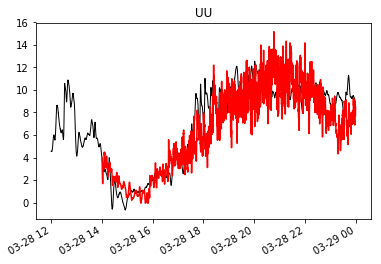

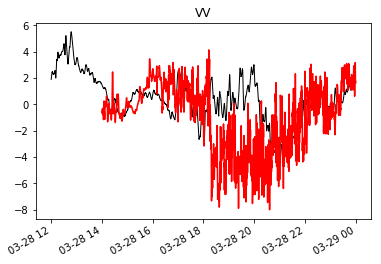

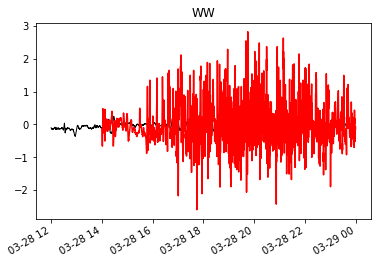

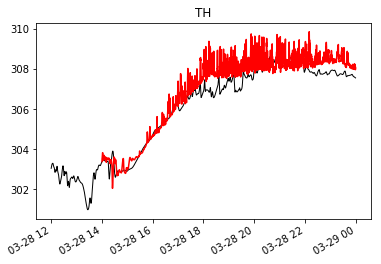

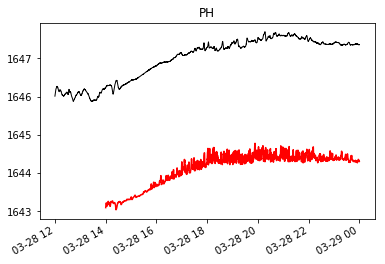

In [88]:
variables = ['UU','VV','WW','TH','PH']

for k in [5]:

    for var in variables:

        index = [ pd.to_datetime(x) for x in all_xArray.XTIME.values ]
        data  = all_xArray[var].isel(bottom_top=k).data
        new   = pd.Series(index=index,data=data)
        plt.figure()
        plt.plot(probeData[var][k],'-k',ms=2,lw=1)
        (new).plot(style='-r')
        plt.title(var)
        
        print (new-probeData[var][k]).dropna().mean()

# Save

In [89]:
for varName in ['UU','VV','WW','TH','PH']:
    df = pd.DataFrame(index=all_xArray['XTIME'],
                 columns=all_xArray['bottom_top'],
                 data=all_xArray[varName].data)
    fName = '{0}_{1:.3f}_{2:.3f}_{3}_{4}.csv'.format(simName,np.unique(all_xArray['XLAT'])[0],np.unique(all_xArray['XLONG'])[0],varName,np.datetime_as_string(np.unique(all_xArray['XTIME'])[0])[0:10])
    df.to_csv(os.path.join(outPath,fName))
    print fName

LES_25_40.050_-105.004_UU_2015-03-28.csv
LES_25_40.050_-105.004_VV_2015-03-28.csv
LES_25_40.050_-105.004_WW_2015-03-28.csv
LES_25_40.050_-105.004_TH_2015-03-28.csv
LES_25_40.050_-105.004_PH_2015-03-28.csv
